### Lagrangian diagnostics from filtered and demodulated signal
cf github/zcasparco/equinox_phd/llc4320/signal_filtering_storeL.ipynb for filtering and demodulation method

1) Quick first look at instanteanous diagnostics : phase and amplitude

2) Compute Lagrangian autocovariance of demodulated signal

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

In [2]:

from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5) #processes=7, cores=7
#
w = cluster.scale(jobs=7)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

#run_name_old = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'lpass_filtered_iprime_05cpd' #_iprime
#'filtered_itide_Tw30_sd_band04'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
#df = pa.degs2ms(df)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,waterdepth,mean_sea_level,mean_zonal_velocity,mean_meridional_velocity,zonal_velocity_iprime,meridional_velocity_iprime,zonal_velocity_iprime_hat,meridional_velocity_iprime_hat
time,,,,,,,,,,,,,,,
2011-11-15,2000332,-68.788177,-21.312500,0.0,0.0,0.0,0.0,0.0,-2.065264,-0.032635,0.001503,0.032635,-0.001503,-0.016854,-0.034280
2011-11-15,26000448,7.831545,132.062500,0.0,0.0,0.0,0.0,0.0,0.969504,-0.133159,0.033771,0.133159,-0.033771,0.187673,-0.177882
2011-11-15,26000607,3.034701,139.354172,0.0,0.0,0.0,0.0,0.0,1.009348,-0.041734,0.051182,0.041734,-0.051182,-0.032613,-0.141249
2011-11-15,26001135,9.751602,161.229172,0.0,0.0,0.0,0.0,0.0,0.933084,-0.196169,0.049958,0.196169,-0.049958,0.165535,-0.042095
2011-11-15,26001184,8.802592,163.312500,0.0,0.0,0.0,0.0,0.0,0.909380,-0.127678,0.037334,0.127678,-0.037334,0.170332,-0.061231


In [4]:
#Add a column flagging where the depth is olower than 500m
df['depth_flag'] = df['waterdepth'].map_partitions(lambda x : x.where(x>500).fillna(0)).persist()


In [7]:
#time = df.index.compute()
time = np.unique(time)

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


In [15]:
time.dtype

dtype('<M8[ns]')

In [12]:
df.loc[str(time[0])]

TypeError: Cannot compare tz-naive and tz-aware timestamps

In [17]:
t_size = []
for t in np.unique(time):
    t_size.append(time[time==t].size)

KeyboardInterrupt: 

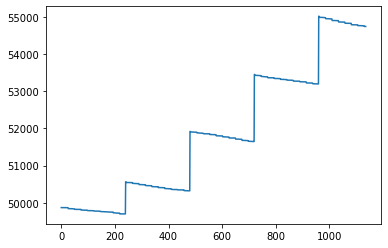

In [19]:
plt.plot(t_size)

In [22]:
_df = df.reset_index().persist()

In [28]:
_df.time.size.compute()

613432621

In [62]:
df.trajectory.sample(frac=1/3,random_state=1).index.compute()#.values.compute()

DatetimeIndex(['2011-11-15 01:00:00', '2011-11-15 02:00:00',
               '2011-11-15 00:00:00', '2011-11-15 02:00:00',
               '2011-11-15 02:00:00', '2011-11-15 02:00:00',
               '2011-11-15 00:00:00', '2011-11-15 02:00:00',
               '2011-11-15 00:00:00', '2011-11-15 02:00:00',
               ...
               '2012-11-09 00:00:00', '2012-11-09 01:00:00',
               '2012-11-09 01:00:00', '2012-11-09 01:00:00',
               '2012-11-09 01:00:00', '2012-11-09 00:00:00',
               '2012-11-09 00:00:00', '2012-11-09 00:00:00',
               '2012-11-09 00:00:00', '2012-11-09 00:00:00'],
              dtype='datetime64[ns]', name='time', length=204477537, freq=None)

In [71]:
traj = df.trajectory.compute()

In [77]:
traj.loc[time[::3]]

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2aabaebea610>>
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/utils_perf.py", line 182, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [85]:
print(_df.time._meta.dtypes,_df.time.compute().dtypes)

datetime64[ns] datetime64[ns]


In [89]:
pd.to_datetime(time,utc=True)

DatetimeIndex(['2011-11-15 00:00:00+00:00', '2011-11-15 00:00:00+00:00',
               '2011-11-15 00:00:00+00:00', '2011-11-15 00:00:00+00:00',
               '2011-11-15 00:00:00+00:00', '2011-11-15 00:00:00+00:00',
               '2011-11-15 00:00:00+00:00', '2011-11-15 00:00:00+00:00',
               '2011-11-15 00:00:00+00:00', '2011-11-15 00:00:00+00:00',
               ...
               '2012-11-09 01:00:00+00:00', '2012-11-09 01:00:00+00:00',
               '2012-11-09 01:00:00+00:00', '2012-11-09 01:00:00+00:00',
               '2012-11-09 01:00:00+00:00', '2012-11-09 01:00:00+00:00',
               '2012-11-09 01:00:00+00:00', '2012-11-09 01:00:00+00:00',
               '2012-11-09 01:00:00+00:00', '2012-11-09 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=613432621, freq=None)

In [90]:
_df["time_bis"] = _df['time'].map_partitions(lambda x : pd.to_datetime(x,utc=True)).persist()

In [93]:
_df = _df.sort_values('time_bis').set_index('time_bis')

In [97]:
_df = _df.reset_index()
_df.time_bis._meta.dtypes

datetime64[ns, UTC]

In [98]:
_df.time_bis.compute().dtypes

datetime64[ns, UTC]

In [75]:
traj_2 = df.trajectory.resample('3H').sum().compute()

TypeError: Cannot compare tz-naive and tz-aware datetime-like objects.

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('read-parquet-getitem-70c250b30a58d490ce4cf23ed33341bb', 134)"
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/da

In [7]:
time = df.loc[::3].index.compute()

In [8]:
np.unique(time)

array(['2011-11-15T00:00:00.000000000', '2011-11-15T01:00:00.000000000',
       '2011-11-15T02:00:00.000000000', ...,
       '2012-11-08T23:00:00.000000000', '2012-11-09T00:00:00.000000000',
       '2012-11-09T01:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
df = df[df.time==time[::3]]

ValueError: Metadata inference failed in `eq`.

Original error is below:
------------------------
ValueError('Lengths must match to compare', (2,), (2881,))

Traceback:
---------
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/utils.py", line 175, in raise_on_meta_error
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py", line 5172, in elemwise
    meta = partial_by_order(*parts, function=op, other=other)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/utils.py", line 1107, in partial_by_order
    return function(*args2, **kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/core/ops/common.py", line 65, in new_method
    return method(self, other)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/core/ops/__init__.py", line 370, in wrapper
    res_values = comparison_op(lvalues, rvalues, op)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/core/ops/array_ops.py", line 224, in comparison_op
    raise ValueError(


### Instantaneous (phase and amplitude)

In [4]:
# Reconstruct the complex demodulated analytic signal
v = 'zonal_velocity'
df[v+'_demodulated'] = (df[v+'_demodulated_real']+1j*df[v+'_demodulated_imag']).persist()
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,dt_flag,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag,zonal_velocity_demodulated
time,,,,,,,,,,,,,,,,,,,
2011-11-15,2000180,-69.537819,-27.562500,0.0,0.0,0.0,0.0,0.0,0.0,False,0.003860,0.000828,0.003860,0.000828,0.001959,0.004701,0.001959,0.004701,0.003860+0.000828j
2011-11-15,32001633,-68.398026,-111.145836,0.0,0.0,0.0,0.0,0.0,0.0,False,0.010257,-0.006823,0.010257,-0.006823,0.006176,-0.005051,0.006176,-0.005051,0.010257-0.006823j
2011-11-15,33000001,-60.259064,-178.854172,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.018617,-0.000236,-0.018617,-0.000236,-0.002741,-0.001225,-0.002741,-0.001225,-0.018617-0.000236j
2011-11-15,33000332,-57.061897,-165.312500,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.005545,-0.002806,-0.005545,-0.002806,-0.020069,0.000412,-0.020069,0.000412,-0.005545-0.002806j
2011-11-15,33001023,-47.411320,-137.187500,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.011063,-0.002011,-0.011063,-0.002011,-0.002488,0.009116,-0.002488,0.009116,-0.011063-0.002011j


In [4]:
#binsize = 2
lonmin,lonmax = np.around(df.lon.min().compute()),np.around(df.lon.max().compute())
latmin,latmax = np.around(df.lat.min().compute()),np.around(df.lat.max().compute())
#lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)

In [6]:
# Compute phase and amplitude of the filtered and demodulated analytic signal
df[v+'_demodulated_phase'] = df[v+'_demodulated'].apply(lambda x : np.angle(x))
df[v+'_demodulated_ampl'] = df[v+'_demodulated'].apply(lambda x : np.abs(x))

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('zonal_velocity_demodulated', 'float64'))

  warnings.warn(meta_warning(meta))


In [7]:
_df = df[df.trajectory==37000596].compute()

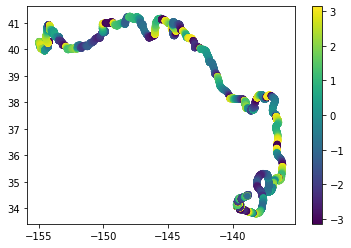

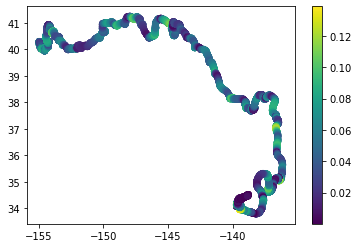

In [8]:
im = plt.scatter(_df.lon,_df.lat,c=_df[v+'_demodulated_phase'])
plt.colorbar(im)
plt.figure()
im = plt.scatter(_df.lon,_df.lat,c=_df[v+'_demodulated_ampl'])
plt.colorbar(im)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


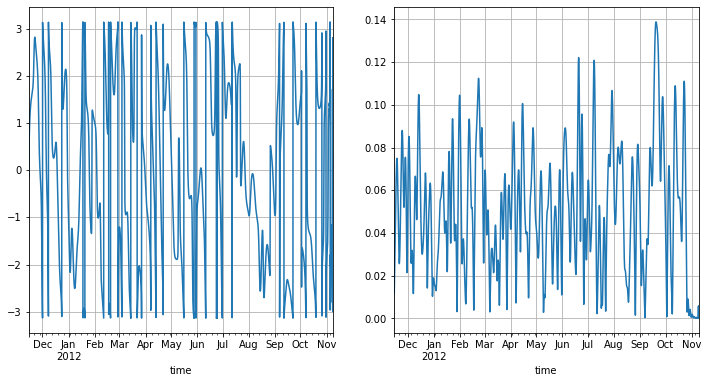

In [14]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
_df.zonal_velocity_demodulated_phase.plot(ax=axs[0])
_df.zonal_velocity_demodulated_ampl.plot(ax=axs[1])
for ax in axs:
    ax.grid()

### Compute autocovariance

In [5]:
def time_window_processing(df, myfun, columns, T, N, overlap=0.5,remove_any=True, **myfun_kwargs):
    ''' break each drifter time series into time windows and process each windows
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        T: float
            Length of the time windows
            
        myfun
            Method that will be applied to each window
            
        columns: list of str
            List of columns of df that will become inputs of myfun
            
        N: int
            Length of myfun outputs
            
        L: int
            Maximum x (used in mean_position)
            
        overlap: float
            Amount of overlap between windows. 
            Should be between 0 and 1. 
            Default is 0.5
            
        **myfun_kwargs
            Keyword arguments for myfun
    
    '''
    if hasattr(df, 'trajectory'):
        dr_id = df.trajectory.unique()[0]
    elif df.index.name=='trajectory':
        dr_id = df.index.unique()[0]
    elif hasattr(df, 'name'):
        # when mapped after groupby
        dr_id = df.name
    else:
        assert False, 'Cannot find float id'
    #
    _df = df.sort_values('time')#.set_index('time')
    time_float = [float(i)/(3600*1e9*24) for i in _df.time.values[:]-_df.time.values[0]]
#    print(time_float[0])
    _df['time_float'] = time_float
    _df = _df.set_index('time_float')
    tmin, tmax = _df.index[0], _df.index[-1]
    # need to create an empty dataframe, in case the loop below is empty
    myfun_out = myfun(*[None for c in columns], N, **myfun_kwargs) # get index from fake output
    index = ['lon','lat']+['id']+['waterdepth']+list(myfun_out.index)
    out = [pd.DataFrame({_:[] for _ in index})]
    t=tmin
    while t+T<tmax:
        #
        _p = _df.loc[t:t+T]
        _pmean = _p.loc[t+T//2:+T]
        # compute average position
#        x, y = _p.lon.mean(),_p.lat.mean()#mean_position(_p, L)
        x, y = _pmean.lon.mean(),_pmean.lat.mean()#mean_position(_p, L)
        if remove_any==True:
            if _pmean.depth_flag[_pmean.depth_flag==True].size>=10*24:
                waterdepth = 0.0
            else:
                waterdepth = _pmean.waterdepth.mean()
        else : 
            waterdepth = _pmean.waterdepth.mean()
        # apply myfun
        print(t+T)
        myfun_out = myfun(*[_p[c] for c in columns], N, **myfun_kwargs)
        # combine with mean position and time
        _out = pd.DataFrame([[x, y]+[dr_id]+[waterdepth]+list(myfun_out)],
                            columns = index,
                            index = [t+T/2.])
        out.append(_out)
        t+=T*(1-overlap)
    return pd.concat(out)

def correlate(v1, v2, N, detrend = False, dt=None):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not Provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    if dt is None:
        dt = v1.reset_index()['index'].diff().mean()
    
    if v1 is None and v2 is None:
        _v1 = np.random.randn(N)
        _v2 = np.random.randn(N)
        vv = np.correlate(_v1[N//2:], _v2, mode='valid')
    else:
        if detrend:
            _v1 = v1
            _v2 = v2
            v1 = signal.detrend(v1)
            v2 = signal.detrend(v2)
        #print('!!! Not implemented yet')
        # https://www.machinelearningplus.com/time-series/time-series-analysis-python/
        
        vv = np.correlate(v1.iloc[N//2:], v2, mode='valid')/(N/2)
    out = vv[:][:N]
    index=list(np.arange(N//2+1)*dt)
    return pd.Series(out,index=index)

In [6]:
def wrap_correlate(df,columns,T,N,dt,binsize):
    """Wrap the correlation computation functions
    """
    df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()
    df_chunked = df_chunked.reset_index().rename(columns={'level_1': 'time'})
#    lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
#    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
#    df_chunked['lon_cut'] = df_chunked['lon'].map_partitions(pd.cut, bins=lon_bins)
#   df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)
    return df_chunked

In [7]:
dt = 1/24
T=80
N=int(T/dt)

In [8]:
_df = df
_df = _df.reset_index().set_index('trajectory').persist()

In [9]:
_df.head()

,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,waterdepth,mean_sea_level,mean_zonal_velocity,mean_meridional_velocity,zonal_velocity_iprime,meridional_velocity_iprime,zonal_velocity_iprime_hat,meridional_velocity_iprime_hat,depth_flag
trajectory,,,,,,,,,,,,,,,,
1000000,2012-01-26 00:00:00,-77.923425,-40.763509,0.0,-0.033100,-0.039607,-2.653985,893.183472,-2.410593,-0.013054,0.006162,-0.020046,-0.045769,-0.033222,-0.041804,893.183472
1000000,2012-07-04 17:00:00,-77.052038,-48.429539,0.0,-0.072528,0.093117,-1.744572,251.000000,-2.547448,-0.032432,0.032212,-0.040096,0.060905,-0.002880,0.020292,0.000000
1000000,2012-02-07 21:00:00,-77.966321,-41.861542,0.0,-0.029987,0.034710,-2.061658,749.820007,-2.433393,-0.023361,0.001193,-0.006626,0.033517,-0.012303,0.009433,749.820007
1000000,2012-02-07 22:00:00,-77.965199,-41.865325,0.0,-0.018718,0.033909,-2.366759,747.354736,-2.433146,-0.023363,0.001177,0.004645,0.032731,-0.010090,0.012841,747.354736
1000000,2012-07-04 16:00:00,-77.054949,-48.419053,0.0,-0.073007,0.085994,-1.918915,251.178879,-2.546390,-0.032253,0.031498,-0.040753,0.054496,-0.002706,0.020562,0.000000


In [14]:
# real-real autocovariance
#remove_any = False
dl = 2
#v1,v2 = 'meridional_velocity_demodulated_real','meridional_velocity_demodulated_real'
#v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_real'
#v1,v2 = 'meridional_velocity_hat_real','meridional_velocity_hat_real'
v1,v2 = 'meridional_velocity_iprime_hat','meridional_velocity_iprime_hat'
df_autocorr_rr = wrap_correlate(_df,[v1,v2],T,N,dt,binsize=dl)
df_autocorr_rr

/dev/shm/pbs.455680.datarmor0/ipykernel_27733/3284118775.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()


,trajectory,time,lon,lat,id,waterdepth,0.0,0.041666666666666664,0.08333333333333333,0.125,0.16666666666666666,0.20833333333333331,0.25,0.29166666666666663,0.3333333333333333,0.375,0.41666666666666663,0.4583333333333333,0.5,0.5416666666666666,0.5833333333333333,0.625,0.6666666666666666,0.7083333333333333,0.75,0.7916666666666666,0.8333333333333333,0.875,0.9166666666666666,0.9583333333333333,1.0,1.0416666666666665,1.0833333333333333,1.125,1.1666666666666665,1.2083333333333333,1.25,1.2916666666666665,1.3333333333333333,1.375,1.4166666666666665,1.4583333333333333,1.5,1.5416666666666665,1.5833333333333333,1.625,1.6666666666666665,1.7083333333333333,1.75,1.7916666666666665,1.8333333333333333,1.875,1.9166666666666665,1.9583333333333333,2.0,2.0416666666666665,2.083333333333333,2.125,2.1666666666666665,2.208333333333333,2.25,2.2916666666666665,2.333333333333333,2.375,2.4166666666666665,2.458333333333333,2.5,2.5416666666666665,2.583333333333333,2.625,2.6666666666666665,2.708333333333333,2.75,2.7916666666666665,2.833333333333333,2.875,2.9166666666666665,2.958333333333333,3.0,3.0416666666666665,3.083333333333333,3.125,3.1666666666666665,3.208333333333333,3.25,3.2916666666666665,3.333333333333333,3.375,3.4166666666666665,3.458333333333333,3.5,3.5416666666666665,3.583333333333333,3.625,3.6666666666666665,3.708333333333333,3.75,3.7916666666666665,3.833333333333333,3.875,3.9166666666666665,3.958333333333333,4.0,4.041666666666666,4.083333333333333,4.125,4.166666666666666,4.208333333333333,4.25,4.291666666666666,4.333333333333333,4.375,4.416666666666666,4.458333333333333,4.5,4.541666666666666,4.583333333333333,4.625,4.666666666666666,4.708333333333333,4.75,4.791666666666666,4.833333333333333,4.875,4.916666666666666,4.958333333333333,5.0,5.041666666666666,5.083333333333333,5.125,5.166666666666666,5.208333333333333,5.25,5.291666666666666,5.333333333333333,5.375,5.416666666666666,5.458333333333333,5.5,5.541666666666666,5.583333333333333,5.625,5.666666666666666,5.708333333333333,5.75,5.791666666666666,5.833333333333333,5.875,5.916666666666666,5.958333333333333,6.0,6.041666666666666,6.083333333333333,6.125,6.166666666666666,6.208333333333333,6.25,6.291666666666666,6.333333333333333,6.375,6.416666666666666,6.458333333333333,6.5,6.541666666666666,6.583333333333333,6.625,6.666666666666666,6.708333333333333,6.75,6.791666666666666,6.833333333333333,6.875,6.916666666666666,6.958333333333333,7.0,7.041666666666666,7.083333333333333,7.125,7.166666666666666,7.208333333333333,7.25,7.291666666666666,7.333333333333333,7.375,7.416666666666666,7.458333333333333,7.5,7.541666666666666,7.583333333333333,7.625,7.666666666666666,7.708333333333333,7.75,7.791666666666666,7.833333333333333,7.875,7.916666666666666,7.958333333333333,8.0,8.041666666666666,8.083333333333332,8.125,8.166666666666666,8.208333333333332,8.25,8.291666666666666,8.333333333333332,8.375,8.416666666666666,8.458333333333332,8.5,8.541666666666666,8.583333333333332,8.625,8.666666666666666,8.708333333333332,8.75,8.791666666666666,8.833333333333332,8.875,8.916666666666666,8.958333333333332,9.0,9.041666666666666,9.083333333333332,9.125,9.166666666666666,9.208333333333332,9.25,9.291666666666666,9.333333333333332,9.375,9.416666666666666,9.458333333333332,9.5,9.541666666666666,9.583333333333332,9.625,9.666666666666666,9.708333333333332,9.75,9.791666666666666,9.833333333333332,9.875,9.916666666666666,9.958333333333332,10.0,10.041666666666666,10.083333333333332,10.125,10.166666666666666,10.208333333333332,10.25,10.291666666666666,10.333333333333332,10.375,10.416666666666666,10.458333333333332,10.5,10.541666666666666,10.583333333333332,10.625,10.666666666666666,10.708333333333332,10.75,10.791666666666666,10.833333333333332,10.875,10.916666666666666,10.958333333333332,11.0,11.041666666666666,11.083333333333332,11.125,11.166666666666666,11.208333333333332,11.25,11.291666666666666,11.333333333333332,11.375,11.416666666666666,11.458333333333332,11.5,11.541666666666666,11.583333333333332,11.625,11.666666666666666,11.708

In [208]:
df_autocorr_rr.lon.mean().compute()

ValueError: first array argument cannot be empty

In [18]:
# real-imag autocovariance
dl=2
#v1,v2 = 'meridional_velocity_demodulated_real','meridional_velocity_demodulated_imag'
v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_imag'
df_autocorr_ri = wrap_correlate(df,[v1,v2],T,N,dt,binsize=dl)
df_autocorr_ri

/dev/shm/pbs.9845697.datarmor0/ipykernel_57295/3284118775.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()


Dask DataFrame Structure:
                trajectory   time      lon      lat       id waterdepth      0.0 0.041666666666666664 0.08333333333333333    0.125 0.16666666666666666 0.20833333333333331     0.25 0.29166666666666663 0.3333333333333333    0.375 0.41666666666666663 0.4583333333333333      0.5 0.5416666666666666 0.5833333333333333    0.625 0.6666666666666666 0.7083333333333333     0.75 0.7916666666666666 0.8333333333333333    0.875 0.9166666666666666 0.9583333333333333      1.0 1.0416666666666665 1.0833333333333333    1.125 1.1666666666666665 1.2083333333333333     1.25 1.2916666666666665 1.3333333333333333    1.375 1.4166666666666665 1.4583333333333333      1.5 1.5416666666666665 1.5833333333333333    1.625 1.6666666666666665 1.7083333333333333     1.75 1.7916666666666665 1.8333333333333333    1.875 1.9166666666666665 1.9583333333333333      2.0 2.0416666666666665 2.083333333333333    2.125 2.1666666666666665 2.208333333333333     2.25 2.2916666666666665 2.333333333333333    2.375 2.4166666666666665 2.458333333333333      2.5 2.5416666666666665 2.583333333333333    2.625 2.6666666666666665 2.708333333333333     2.75 2.7916666666666665 2.833333333333333    2.875 2.9166666666666665 2.958333333333333      3.0 3.0416666666666665 3.083333333333333    3.125 3.1666666666666665 3.208333333333333     3.25 3.2916666666666665 3.333333333333333    3.375 3.4166666666666665 3.458333333333333      3.5 3.5416666666666665 3.583333333333333    3.625 3.6666666666666665 3.708333333333333     3.75 3.7916666666666665 3.833333333333333    3.875 3.9166666666666665 3.958333333333333      4.0 4.041666666666666 4.083333333333333    4.125 4.166666666666666 4.208333333333333     4.25 4.291666666666666 4.333333333333333    4.375 4.416666666666666 4.458333333333333      4.5 4.541666666666666 4.583333333333333    4.625 4.666666666666666 4.708333333333333     4.75 4.791666666666666 4.833333333333333    4.875 4.916666666666666 4.958333333333333      5.0 5.041666666666666 5.083333333333333    5.125 5.166666666666666 5.208333333333333     5.25 5.291666666666666 5.333333333333333    5.375 5.416666666666666 5.458333333333333      5.5 5.541666666666666 5.583333333333333    5.625 5.666666666666666 5.708333333333333     5.75 5.791666666666666 5.833333333333333    5.875 5.916666666666666 5.958333333333333      6.0 6.041666666666666 6.083333333333333    6.125 6.166666666666666 6.208333333333333     6.25 6.291666666666666 6.333333333333333    6.375 6.416666666666666 6.458333333333333      6.5 6.541666666666666 6.583333333333333    6.625 6.666666666666666 6.708333333333333     6.75 6.791666666666666 6.833333333333333    6.875 6.916666666666666 6.958333333333333      7.0 7.041666666666666 7.083333333333333    7.125 7.166666666666666 7.208333333333333     7.25 7.291666666666666 7.333333333333333    7.375 7.416666666666666 7.458333333333333      7.5 7.541666666666666 7.583333333333333    7.625 7.666666666666666 7.708333333333333     7.75 7.791666666666666 7.833333333333333    7.875 7.916666666666666 7.958333333333333      8.0 8.041666666666666 8.083333333333332    8.125 8.166666666666666 8.208333333333332     8.25 8.291666666666666 8.333333333333332    8.375 8.416666666666666 8.458333333333332      8.5 8.541666666666666 8.583333333333332    8.625 8.666666666666666 8.708333333333332     8.75 8.791666666666666 8.833333333333332    8.875 8.916666666666666 8.958333333333332      9.0 9.041666666666666 9.083333333333332    9.125 9.166666666666666 9.208333333333332     9.25 9.291666666666666 9.333333333333332    9.375 9.416666666666666 9.458333333333332      9.5 9.541666666666666 9.583333333333332    9.625 9.666666666666666 9.708333333333332     9.75 9.791666666666666 9.833333333333332    9.875 9.916666666666666 9.958333333333332     10.0 10.041666666666666 10.083333333333332   10.125 10.166666666666666 10.208333333333332    10.25 10.291666666666666 10.333333333333332   10.375 10.416666666666666 10.458333333333332     10.5 10.541666666666666 10.583333333333332   10.625 10.

In [15]:
df_autocorr_rr = df_autocorr_rr.rename(columns={c:str(c) for c in df_autocorr_rr.columns}).persist()

In [16]:
df_autocorr_rr

,trajectory,time,lon,lat,id,waterdepth,0.0,0.041666666666666664,0.08333333333333333,0.125,0.16666666666666666,0.20833333333333331,0.25,0.29166666666666663,0.3333333333333333,0.375,0.41666666666666663,0.4583333333333333,0.5,0.5416666666666666,0.5833333333333333,0.625,0.6666666666666666,0.7083333333333333,0.75,0.7916666666666666,0.8333333333333333,0.875,0.9166666666666666,0.9583333333333333,1.0,1.0416666666666665,1.0833333333333333,1.125,1.1666666666666665,1.2083333333333333,1.25,1.2916666666666665,1.3333333333333333,1.375,1.4166666666666665,1.4583333333333333,1.5,1.5416666666666665,1.5833333333333333,1.625,1.6666666666666665,1.7083333333333333,1.75,1.7916666666666665,1.8333333333333333,1.875,1.9166666666666665,1.9583333333333333,2.0,2.0416666666666665,2.083333333333333,2.125,2.1666666666666665,2.208333333333333,2.25,2.2916666666666665,2.333333333333333,2.375,2.4166666666666665,2.458333333333333,2.5,2.5416666666666665,2.583333333333333,2.625,2.6666666666666665,2.708333333333333,2.75,2.7916666666666665,2.833333333333333,2.875,2.9166666666666665,2.958333333333333,3.0,3.0416666666666665,3.083333333333333,3.125,3.1666666666666665,3.208333333333333,3.25,3.2916666666666665,3.333333333333333,3.375,3.4166666666666665,3.458333333333333,3.5,3.5416666666666665,3.583333333333333,3.625,3.6666666666666665,3.708333333333333,3.75,3.7916666666666665,3.833333333333333,3.875,3.9166666666666665,3.958333333333333,4.0,4.041666666666666,4.083333333333333,4.125,4.166666666666666,4.208333333333333,4.25,4.291666666666666,4.333333333333333,4.375,4.416666666666666,4.458333333333333,4.5,4.541666666666666,4.583333333333333,4.625,4.666666666666666,4.708333333333333,4.75,4.791666666666666,4.833333333333333,4.875,4.916666666666666,4.958333333333333,5.0,5.041666666666666,5.083333333333333,5.125,5.166666666666666,5.208333333333333,5.25,5.291666666666666,5.333333333333333,5.375,5.416666666666666,5.458333333333333,5.5,5.541666666666666,5.583333333333333,5.625,5.666666666666666,5.708333333333333,5.75,5.791666666666666,5.833333333333333,5.875,5.916666666666666,5.958333333333333,6.0,6.041666666666666,6.083333333333333,6.125,6.166666666666666,6.208333333333333,6.25,6.291666666666666,6.333333333333333,6.375,6.416666666666666,6.458333333333333,6.5,6.541666666666666,6.583333333333333,6.625,6.666666666666666,6.708333333333333,6.75,6.791666666666666,6.833333333333333,6.875,6.916666666666666,6.958333333333333,7.0,7.041666666666666,7.083333333333333,7.125,7.166666666666666,7.208333333333333,7.25,7.291666666666666,7.333333333333333,7.375,7.416666666666666,7.458333333333333,7.5,7.541666666666666,7.583333333333333,7.625,7.666666666666666,7.708333333333333,7.75,7.791666666666666,7.833333333333333,7.875,7.916666666666666,7.958333333333333,8.0,8.041666666666666,8.083333333333332,8.125,8.166666666666666,8.208333333333332,8.25,8.291666666666666,8.333333333333332,8.375,8.416666666666666,8.458333333333332,8.5,8.541666666666666,8.583333333333332,8.625,8.666666666666666,8.708333333333332,8.75,8.791666666666666,8.833333333333332,8.875,8.916666666666666,8.958333333333332,9.0,9.041666666666666,9.083333333333332,9.125,9.166666666666666,9.208333333333332,9.25,9.291666666666666,9.333333333333332,9.375,9.416666666666666,9.458333333333332,9.5,9.541666666666666,9.583333333333332,9.625,9.666666666666666,9.708333333333332,9.75,9.791666666666666,9.833333333333332,9.875,9.916666666666666,9.958333333333332,10.0,10.041666666666666,10.083333333333332,10.125,10.166666666666666,10.208333333333332,10.25,10.291666666666666,10.333333333333332,10.375,10.416666666666666,10.458333333333332,10.5,10.541666666666666,10.583333333333332,10.625,10.666666666666666,10.708333333333332,10.75,10.791666666666666,10.833333333333332,10.875,10.916666666666666,10.958333333333332,11.0,11.041666666666666,11.083333333333332,11.125,11.166666666666666,11.208333333333332,11.25,11.291666666666666,11.333333333333332,11.375,11.416666666666666,11.458333333333332,11.5,11.541666666666666,11.583333333333332,11.625,11.666666666666666,11.708

In [17]:
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], df_autocorr_rr, overwrite=True, name="autocov_low_SSV_mean1_flag10")

No reindexing
create new archive: /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/autocov_low_SSV_mean1_flag10


'/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/autocov_low_SSV_mean1_flag10'

In [19]:
#df_autocorr_ri = df_autocorr_ri.drop(columns=['lon_cut','lat_cut'])
df_autocorr_ri = df_autocorr_ri.rename(columns={c:str(c) for c in df_autocorr_ri.columns}).persist()


In [20]:
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], df_autocorr_ri, overwrite=True, name="autocov_demodulation_ri_flag10_T80")

No reindexing
create new archive: /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/autocov_demodulation_ri_flag10_T80


'/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/autocov_demodulation_ri_flag10_T80'

In [21]:
#client.restart()
#
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [1]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4
                 )
#
client = Client(cluster)

#### Loading autocovariances

In [41]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

#run_name_old = 'global_extra_T365j_dt1j_dij50'
parcels_index = ['autocov_demodulation_vr_vr','autocov_demodulation_vr_vi']
name_list = ['rr','ri']
df = {}
for i,parcels_id in enumerate(parcels_index):
# choose to select time indexed data for now
    p = pa.parcels_output(root_dir+run_name, parquets=[parcels_id])
    name = name_list[i]
    df[name] = p[parcels_id]
df['rr'].head()

AssertionError: autocov_demodulation_vr_vr parquet file does not exist

In [7]:
#grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']].persist()

In [5]:
# add bathymetry to dataframe
def interp_bathy(df):
    bathy = ut.load_bathy(15)
    ds = df[['lon','lat']].to_xarray()
    ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
    df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
    return df.assign(**{bathy.name: df_interpolated})

for k in df.keys():
    df[k]= df[k].map_partitions(interp_bathy)
#df_ri = df_ri.map_partitions(interp_bathy)

In [22]:
lat,lon,h = df['rr'].lat.values.compute(),df['rr'].lon.values.compute(),df['rr'].h.values.compute()

In [6]:
for k in df.keys():
    df[k] = df[k].where(df[k].h>500).persist()
#df_ri = df_ri.mask(df.h<500)

In [24]:
lat_500,lon_500,h_500 = df['rr'].lat.values,df['rr'].lon.values,df['rr'].h.values

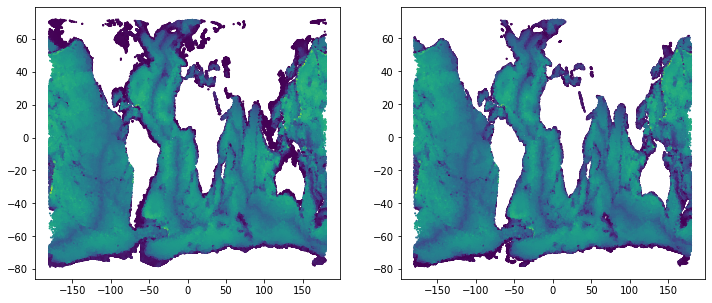

In [18]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(lon,lat,c=h,s=1)
ax[1].scatter(lon_500.compute(),lat_500.compute(),c=h_500.compute(),s=1)

(-180.0, 180.0)

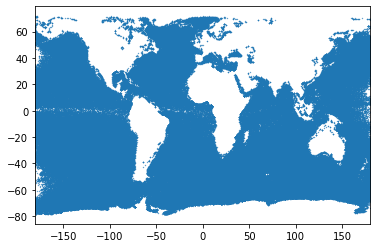

In [21]:
plt.scatter(df['rr'].lon.values.compute(),df['rr'].lat.values.compute(),s=1/10)
plt.xlim(-180,180)

In [7]:
lonmin,lonmax = np.around(df['rr'].lon.min().compute()),np.around(df['rr'].lon.max().compute())
latmin,latmax = np.around(df['rr'].lat.min().compute()),np.around(df['rr'].lat.max().compute())

In [8]:
binsize = 2
def binning(_df,binsize):
    lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = _df['lon'].map_partitions(pd.cut, bins=lon_bins)
    _df['lat_cut'] = _df['lat'].map_partitions(pd.cut, bins=lat_bins)
    _df = _df.drop(columns=['id','time','lon','lat','trajectory','h'])
    _df = _df.rename(columns={c:float(c) for c in _df.columns[:-2]})
    return _df
for k in df.keys():
    df[k] = binning(df[k],binsize).persist()
#df_ri['lat_cut'] = df_ri['lat'].map_partitions(pd.cut, bins=lat_bins)

In [9]:
from dask.distributed import wait
df_mean = {}
for k in df.keys():
    df_mean[k] = df[k].groupby(['lon_cut','lat_cut']).apply(lambda x: x.mean(skipna=False)).persist()
    df_mean[k] = df_mean[k].reset_index()
#rr_mean = df['rr'].groupby(['lon_cut','lat_cut']).mean().compute()
#ri_mean = df_ri.groupby(['lon_cut','lat_cut']).mean().compute()

/dev/shm/pbs.8757021.datarmor0/ipykernel_45459/3750693326.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_mean[k] = df[k].groupby(['lon_cut','lat_cut']).apply(lambda x: x.mean(skipna=False)).persist()
/dev/shm/pbs.8757021.datarmor0/ipykernel_45459/3750693326.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_mean[k] = df[k].groupby(['lon_cut','lat_cut']).apply(lambda x: x.mean(skipna=False)).persist()


#### Converting pandas dataframe in xarray dataset:

In [33]:
#df_melted = {}
k = 'ri'
#for k in df_mean.keys():
df_melted[k] = dd.melt(df_mean[k],id_vars=['lon_cut','lat_cut'],var_name='lags').persist()
df_melted[k]['lon_bins'] = df_melted[k].lon_cut.apply(lambda x :x.mid)
df_melted[k]['lat_bins'] = df_melted[k].lat_cut.apply(lambda x :x.mid)
df_melted[k] = df_melted[k].drop(columns=['lon_cut','lat_cut']).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

In [34]:
df_melted[k] = df_melted[k].compute()

In [ ]:
df_melted

In [35]:
ds = {}
key = 'rr'
ds[key] = df_melted[k].rename(columns={'value': key}).to_xarray()

In [ ]:
ds[key] = ds[key].set_index(index=['lon_bins','lat_bins','lags']).unstack()[key]

In [ ]:
key = 'ri'
ds[key] = df_melted[k].rename(columns={'value': key}).to_xarray()

In [11]:
#df_melted = {}
k = 'rr'
df_melted[k] = dd.melt(df_mean[k],id_vars=['lon_cut','lat_cut'],var_name='lags').compute()

In [13]:
def df2ds(df_melt,key):
    df_melt['lon_bins'] = df_melt.lon_cut.apply(lambda x :x.mid)
    df_melt['lat_bins'] = df_melt.lat_cut.apply(lambda x :x.mid)
    df_melt = df_melt.drop(columns=['lon_cut','lat_cut'])
    ds = df_melt.rename(columns={'value': key}).to_xarray()
    ds = ds.set_index(index=['lon_bins','lat_bins','lags']).unstack()[key]
    return ds#df_melt

In [ ]:
df_melted = {}
df_melted['rr'] = pd.melt(df_mean['rr'],id_vars=['lon_cut','lat_cut'], var_name='lags')

In [32]:
df_melted = {}
for k in df_mean.keys():
    df_melted[k] = melting(df_mean[k])

NameError: name 'melting' is not defined

In [ ]:
ds = {}
#for k in df_mean.keys():
k = 'rr'
ds[k] = df2ds(df_melted[k],k)

In [ ]:
xr.

In [38]:
ds_out = xr.merge([ds[k] for k in ds.keys()])

Text(0.5, 1.0, '')

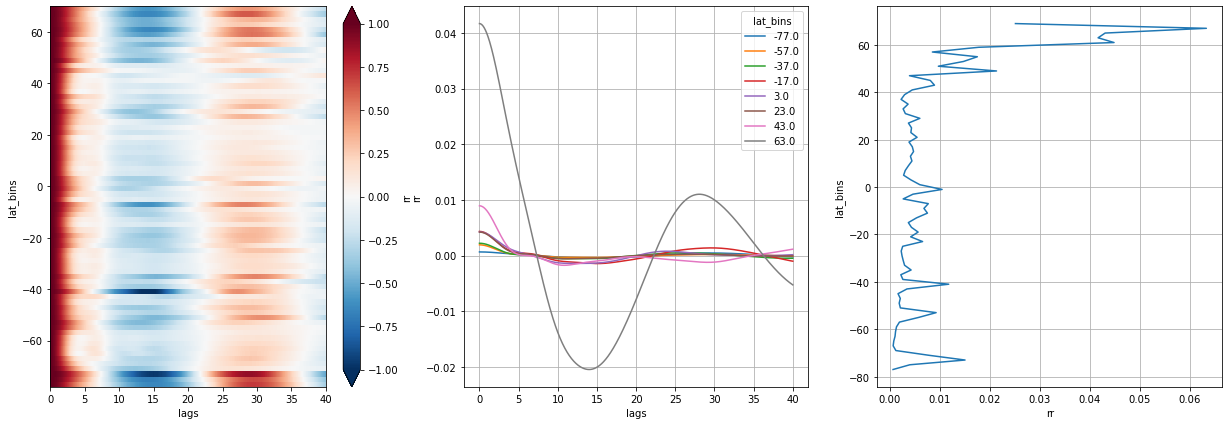

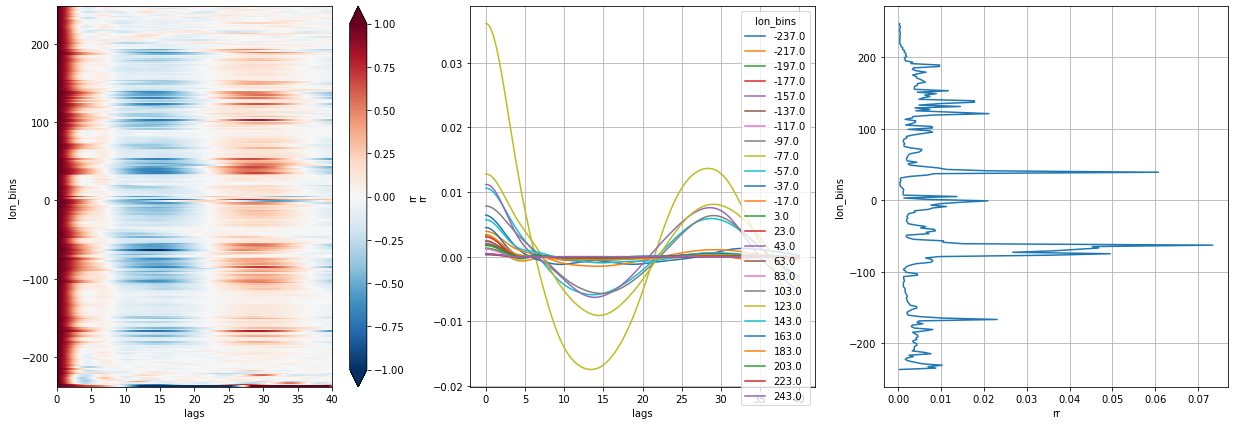

In [39]:
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds_out.mean('lon_bins')/ds_out.mean('lon_bins').isel(lags=0)).rr.plot(ax=ax[0],vmax=1)
(ds_out.mean('lon_bins').isel(lat_bins=slice(0,None,10))).rr.plot(ax=ax[1],hue='lat_bins')
ax[1].grid();
ds_out.mean('lon_bins').isel(lags=0).rr.plot(ax=ax[2],y='lat_bins');ax[2].grid();
ax[2].set_title('')
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds_out.mean('lat_bins')/ds_out.mean('lat_bins').isel(lags=0)).rr.plot(ax=ax[0],vmax=1)
(ds_out.mean('lat_bins').isel(lon_bins=slice(0,None,10))).rr.plot(ax=ax[1],hue='lon_bins')
ax[1].grid();
ds_out.mean('lat_bins').isel(lags=0).rr.plot(ax=ax[2],y='lon_bins');ax[2].grid();
ax[2].set_title('')

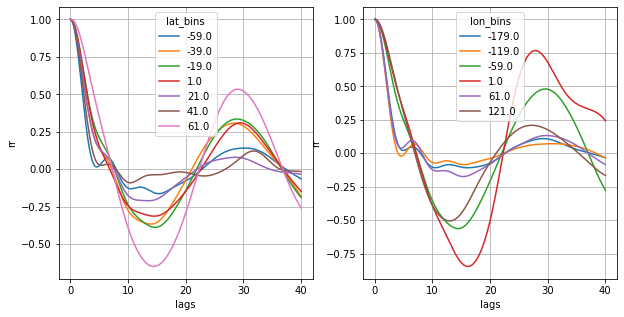

In [40]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
(ds_out.mean('lon_bins')/ds_out.mean('lon_bins').isel(lags=0)).rr.sel(lat_bins=slice(-60,70,10)).plot(hue='lat_bins',ax=axs[0])
(ds_out.mean('lat_bins')/ds_out.mean('lat_bins').isel(lags=0)).rr.sel(lon_bins=slice(-180,180,30)).plot(hue='lon_bins',ax=axs[1])
for ax in axs:
    ax.grid()

Text(0.5, 1.0, '')

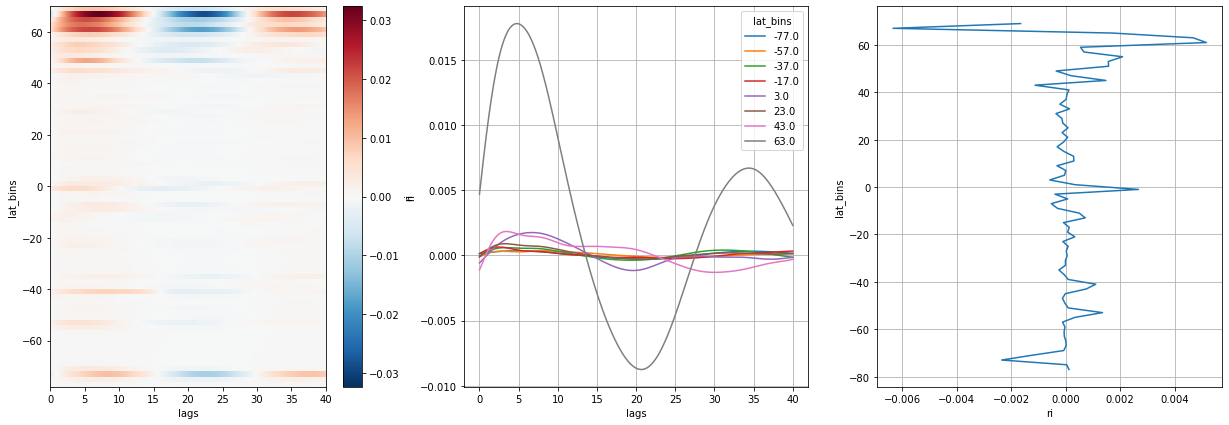

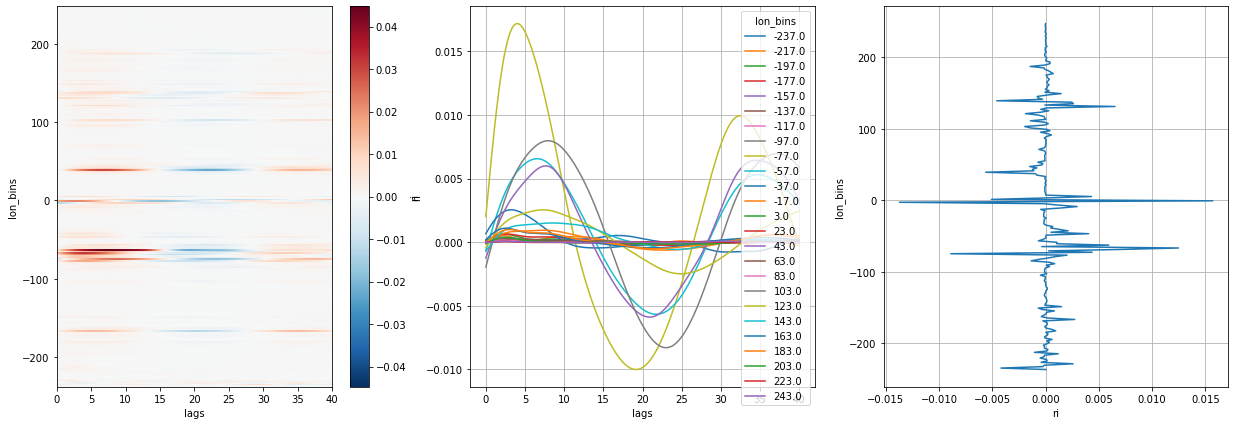

In [41]:
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds_out.mean('lon_bins')).ri.plot(ax=ax[0])
(ds_out.mean('lon_bins').isel(lat_bins=slice(0,None,10))).ri.plot(ax=ax[1],hue='lat_bins')
ax[1].grid();
ds_out.mean('lon_bins').isel(lags=0).ri.plot(ax=ax[2],y='lat_bins');ax[2].grid();
ax[2].set_title('')
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds_out.mean('lat_bins')).ri.plot(ax=ax[0])
(ds_out.mean('lat_bins').isel(lon_bins=slice(0,None,10))).ri.plot(ax=ax[1],hue='lon_bins')
ax[1].grid();
ds_out.mean('lat_bins').isel(lags=0).ri.plot(ax=ax[2],y='lon_bins');ax[2].grid();
ax[2].set_title('')

(-180.0, 180.0)

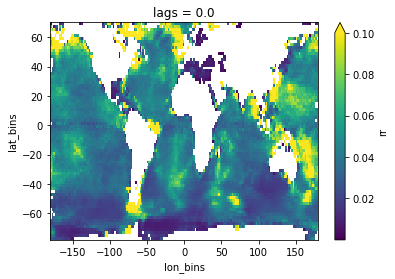

In [42]:
# Autocovariance at lag 0 (~$\widetilde{V}^2)
np.sqrt(ds_out.isel(lags=0).rr).plot(y='lat_bins',vmax=1e-1)
plt.xlim(-180,180)

In [18]:
#client.restart()
#
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
